In [4]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

Plots.GRBackend()

## Non-linear pendulum

## $$
\begin{aligned}
  \dot{q} &= \frac{p}{m l^{2}}\\
  \dot{p} &= - m l g \sin(q)\\
\end{aligned}
$$


In [122]:
function Kuramoto(du, u, p, t)
    ω₁, ω₂, ω₃, ω₄, ω₅, ω₆, ω₇, ω₈, ω₉ = p
    
    du[1] = ω₁ + sin(u[3]-u[1])
    du[2] = ω₂ + (1/2)*sin(u[1]-u[2]) + (1/2)*sin(u[4]-u[2])
    du[3] = ω₃ + sin(u[2]-u[3])
    du[4] = ω₄ + (1/2)*sin(u[5]-u[4]) +  (1/2)*sin(u[1]-u[4])
    du[5] = ω₅ + (1/2)*sin(u[6]-u[5]) + (1/2)*sin(u[3]-u[5]) + (1/2)*sin(u[2]-u[5])
    du[6] = ω₆ + sin(u[3]-u[6])
    du[7] = ω₇ + (1/2)*sin(u[4]-u[7]) + (1/2)*sin(u[3]-u[7]) + (1/2)*sin(u[2]-u[7])
    du[8] = ω₈ + (1/2)*sin(u[1]-u[8]) + (1/2)*sin(u[6]-u[8]) + (1/2)*sin(u[9]-u[8])
    du[9] = ω₉ + (1/2)*sin(u[2]-u[9]) + (1/2)*sin(u[6]-u[9]) + (1/2)*sin(u[2]-u[9])
end


# Define the experimental parameter

tspan = (0.0f0, 20.0f0)
u0 = Float32[0.1, 0.4, 0.1, 0.3, 0.1, 0.6, 0.1, 0.3, 0.1,]
p_ = Float32[1.2, 2.3, 0.2, 1.1, 2.2, 1.3, 2.3, 0.2, 1.1,]

prob = ODEProblem(Kuramoto, u0, tspan, p_)

saveat = 0.05

solution = solve(prob, Vern7(), saveat = saveat) #abstol=1e-12, reltol=1e-12,


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-4)*randn(eltype(X), size(X));

Generate noisy data


## Plot the training data

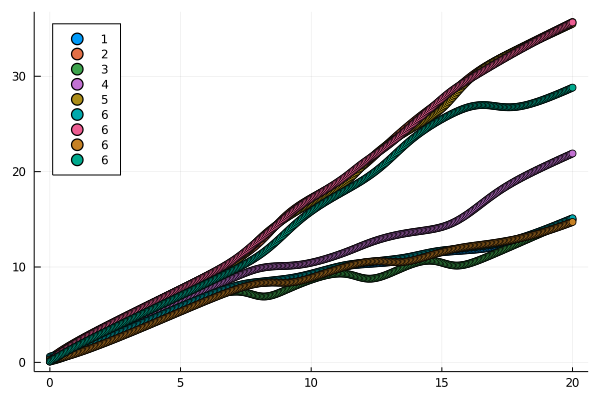

In [125]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
scatter(solution.t, Xₙ[1, :], label = "1", legend=:topleft)
scatter!(solution.t, Xₙ[2, :], label = "2")
scatter!(solution.t, Xₙ[3, :], label = "3")
scatter!(solution.t, Xₙ[4, :], label = "4")
scatter!(solution.t, Xₙ[5, :], label = "5")
scatter!(solution.t, Xₙ[6, :], label = "6")
scatter!(solution.t, Xₙ[7, :], label = "7")
scatter!(solution.t, Xₙ[8, :], label = "8")
scatter!(solution.t, Xₙ[9, :], label = "9")

## In the phase space

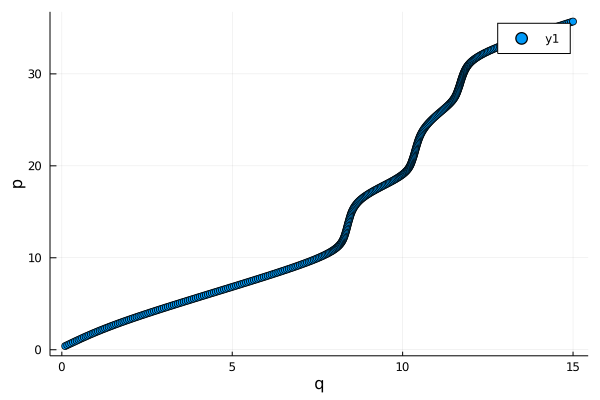

In [126]:
scatter(Array(solution)[1, :], Array(solution)[2, :], xlabel = "q", ylabel = "p")

## UADE

In [128]:
# Neural network

L = FastChain(FastDense(9, 50, tanh), FastDense(50, 50, tanh), FastDense(50, 50, tanh), FastDense(50, 50, tanh), FastDense(50, 9))
p = initial_params(L)


# ODE
function dudt_(u, p, t)
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = u
    z = L(u,p)
    [z[1],
    z[2],
    z[3],
    z[4],
    z[5],
    z[6],
    z[7],
    z[8],
    z[9]]
end

# ODE problem
prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = solution.t);

## Plot the untrained solution

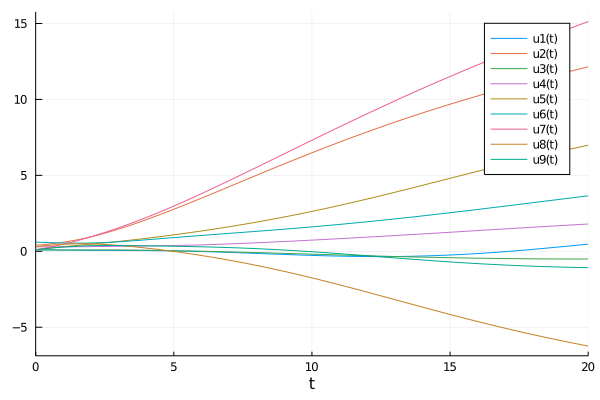

In [129]:
plot(sol_nn)
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss function

In [130]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = solution.t,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training with ADAM

In [ ]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 300)

loss: 7.94e+04:   3%|██                                 |  ETA: 1:30:51

Current loss after 10 iterations: 79409.61


loss: 1.76e+04:   7%|███                                |  ETA: 1:27:45

Current loss after 20 iterations: 17587.246


loss: 5.74e+03:  10%|████                               |  ETA: 1:24:37

Current loss after 30 iterations: 5738.6763


loss: 3.52e+03:  13%|█████                              |  ETA: 1:21:56

Current loss after 40 iterations: 3515.6152


loss: 3.04e+03:  17%|██████                             |  ETA: 1:17:53

Current loss after 50 iterations: 3043.1638


loss: 2.36e+03:  20%|████████                           |  ETA: 1:15:47

Current loss after 60 iterations: 2355.481


loss: 1.86e+03:  23%|█████████                          |  ETA: 1:11:45

Current loss after 70 iterations: 1858.9797


loss: 3.63e+03:  27%|██████████                         |  ETA: 1:09:52

Current loss after 80 iterations: 3629.7305


loss: 1.37e+04:  30%|███████████                        |  ETA: 1:08:41

Current loss after 90 iterations: 13718.475


loss: 4.42e+03:  33%|████████████                       |  ETA: 1:05:52

Current loss after 100 iterations: 4424.333


loss: 3.47e+03:  37%|█████████████                      |  ETA: 1:05:32

Current loss after 110 iterations: 3465.384


loss: 2.9e+03:  40%|███████████████                     |  ETA: 1:00:37

Current loss after 120 iterations: 2903.6067


loss: 2.47e+03:  43%|████████████████                   |  ETA: 0:58:10

Current loss after 130 iterations: 2467.6167


loss: 2.03e+03:  47%|█████████████████                  |  ETA: 0:57:49

Current loss after 140 iterations: 2033.503


loss: 1.69e+03:  50%|██████████████████                 |  ETA: 0:53:35

Current loss after 150 iterations: 1692.6555


loss: 1.45e+03:  53%|███████████████████                |  ETA: 0:50:29

Current loss after 160 iterations: 1453.9932


loss: 1.3e+03:  57%|█████████████████████               |  ETA: 0:48:37

Current loss after 170 iterations: 1303.7026


loss: 1.17e+03:  60%|██████████████████████             |  ETA: 0:46:10

Current loss after 180 iterations: 1170.3601


loss: 1.07e+03:  63%|███████████████████████            |  ETA: 0:41:58

Current loss after 190 iterations: 1071.7316


loss: 994:  67%|███████████████████████████             |  ETA: 0:38:36

Current loss after 200 iterations: 993.7816


loss: 966:  68%|████████████████████████████            |  ETA: 0:37:24

## Training with BFGS

In [57]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 50)

Current loss after 510 iterations: 0.029698139
Current loss after 520 iterations: 0.0066067483


 * Status: failure

 * Candidate solution
    Final objective value:     6.606748e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.52e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.54e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.52e-03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.31e-01 ≰ 0.0e+00
    |g(x)|                 = 2.08e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    18
    f(x) calls:    52
    ∇f(x) calls:   52


## Plot the loss

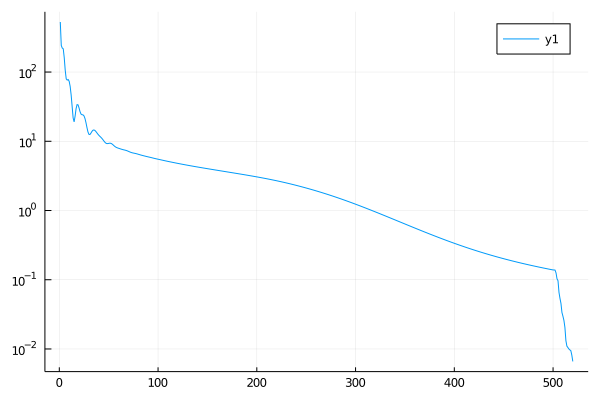

In [58]:
plot(losses, yaxis=:log)

## Plot the prediction

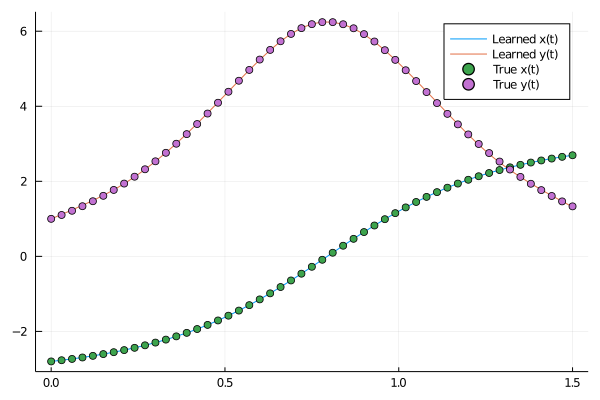

In [59]:
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"])
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Prediction

In [60]:
function dudt_2(u, p, t)
    x, y = u
    z = L(u, p)
    [u[2]/(p_[1]*p_[2]^2),
    z[1]]
end

# ODE problem
tspan2 = (0.0f0, 6.0f0)
prob_nn2 = ODEProblem(dudt_2, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = saveat);

## Test the prediction

In [61]:
prob_test = ODEProblem(H, u0, tspan2, p_)
solution_test = solve(prob_test, Vern7(), saveat = saveat);

## Prot together true and prediction

### Phase space

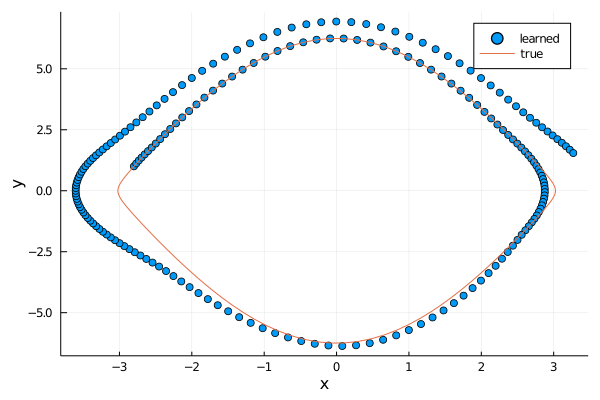

In [62]:
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :], xlabel = "x", ylabel = "y", label = "learned")
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :], label = "true")

## Plot $q(t)$ and $p(t)$

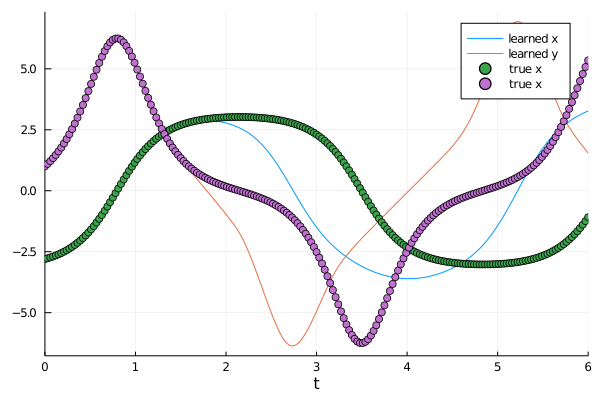

In [63]:
plot(sol_nn2, label = ["learned x" "learned y"])
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true x")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true x")

--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives:
### we take derivatives with respect to $t$ of $(x(t), y(t))$ both from the known solution and the solution to the trained UADE

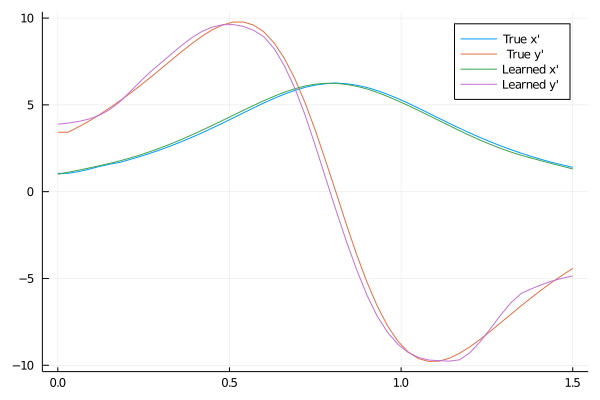

In [64]:
DX = Array(solution(solution.t, Val{1})) 

prob_nn2 = ODEProblem(dudt_2, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())

DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["True x'" " True y'"])
plot!(solution.t, DX_', label = ["Learned x'" "Learned y'"])

## The learned derivatives

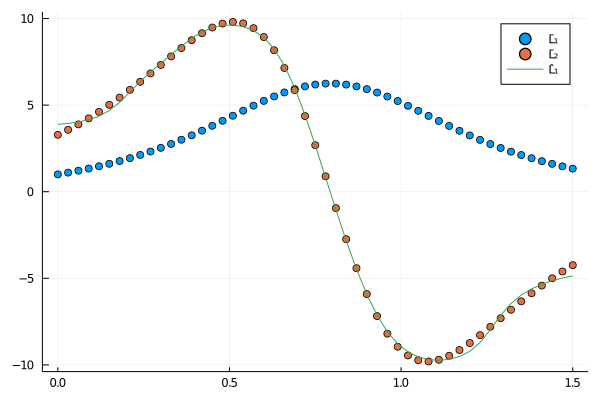

In [65]:
# Ideal data
L̄ = [(Xₙ[2,:]/(p_[1]*p_[2]^(2)))'; -p_[1]*p_[2]*p_[3]*sin.(Xₙ[1,:]')]

# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(solution.t, L̄', label = ["L̄₁" "L̄₂"])
plot!(solution.t, L̂', label = ["L̂₁" "L̂₂"])


#savefig("UADE.png")

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [66]:
@variables u[1:2]

# Lots of polynomials
polys = Operation[1]

for i ∈ 1:5
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i != j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; polys...]
basis = Basis(h, u)

29 dimensional basis in ["u₁", "u₂"]

## Optimizer for the algorithm

In [67]:
opt = SR3() 
#opt = STRRidge(0.1)


# Create the thresholds which should be used in the search process
λ = exp10.(-5:0.1:5)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

#Suggestion from AlCap23
#g(x) = x[1] < 1 ? Inf : norm([0.1; 10.0] .* x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [231]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 10000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 7.604627
   Equation 1 : 2.2014961
   Equation 2 : 5.403131
AICC :
   Equation 1 : -0.906549
   Equation 2 : -4.4979143

SR3{Float64,UnionAll}(0.5, 1.0, ProximalOperators.NormL1) converged after 8691 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = p₁ * u₂
du₂ = sin(u₁) * p₂



## Test on UADE derivative data

In [68]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 50000, normalize = true, denoise = true)
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 3
Active terms : 3
   Equation 1 : 3
Overall error (L2-Norm) : 1.8318648
   Equation 1 : 1.8318648
AICC :
   Equation 1 : 4.4675508

SR3{Float64,UnionAll}(0.12559432157547898, 1.0, ProximalOperators.NormL1) did not converge after 50000 iterations.

1 dimensional basis in ["u₁", "u₂"]
f_1 = sin(u₁) * p₁ + p₂ * u₁ + u₁ ^ 3 * u₂ ^ 3 * p₃



## Extract the parameters

In [69]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-9.418243, -0.043585535, -0.00035321616]


## Define the ODE with the new identified unknown term

In [334]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

AssertionError: AssertionError: length(b) == length(variables(b))

In [70]:
function dudt(du, u, p, t)
    p1 = p
    #z = unknown_eq(u, [p1], t)
    du[1] = u[2]/(p_[1]*p_[2]^2)
    du[2] = p̂[1]*sin(u[1])
end

dudt (generic function with 1 method)

## Create the approximated problem and solution

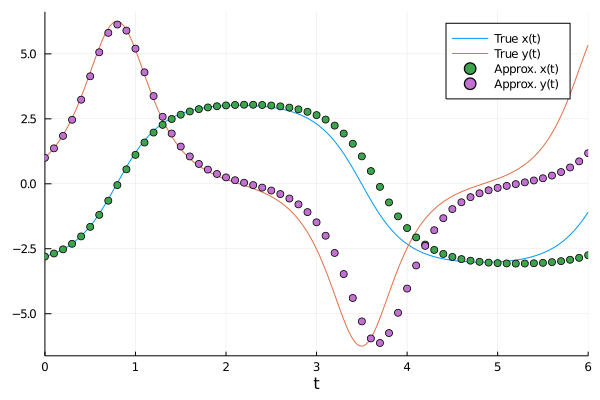

In [72]:
#ps = [p_[[1,2]]; p̂]
tspan = (0.0f0, 6.0f0)
approximate_prob = ODEProblem(dudt, u0, tspan, p̂)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.1)

# Plot
plot(solution_test, label = ["True x(t)" "True y(t)"])
scatter!(approximate_solution, label = ["Approx. x(t)" "Approx. y(t)"])